# Mapping model training

## Setup Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Install Dependencies

First we install the required dependencies with `pip`.

In [2]:
%tensorflow_version 2.x
!pip install -qU ddsp[data_preparation]==1.0.1

     |████████████████████████████████| 174kB 5.8MB/s 
     |████████████████████████████████| 3.6MB 10.1MB/s 
     |████████████████████████████████| 92kB 9.7MB/s 
     |████████████████████████████████| 3.8MB 39.1MB/s 
     |████████████████████████████████| 215kB 44.5MB/s 
     |████████████████████████████████| 9.0MB 43.2MB/s 
     |████████████████████████████████| 378kB 40.1MB/s 
     |████████████████████████████████| 20.2MB 53.2MB/s 
     |████████████████████████████████| 5.6MB 36.5MB/s 
     |████████████████████████████████| 2.2MB 25.2MB/s 
     |████████████████████████████████| 17.7MB 143kB/s 
     |████████████████████████████████| 61kB 6.9MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 112kB 30.8MB/s 
ERROR: apache-beam 2.28.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.
ERROR: apache-beam 2.28.0 has requirement dill<0.3.2,>=0.3.1.1, but you'll have dill

## Make directories to save model and data

In [3]:
import os

drive_dir = '/content/drive/My Drive/nsynth_guitar'
checkpoint_dir = os.path.join(drive_dir, 'mapping/checkpoint')

assert os.path.exists(drive_dir)
print('Drive Directory Exists:', drive_dir)

!mkdir -p "$checkpoint_dir"

Drive Directory Exists: /content/drive/My Drive/nsynth_guitar


## Clear existing checkpoints

In [4]:
# import shutil

# try:
#     shutil.rmtree(checkpoint_dir)
# except OSError as e:
#     print("Error: %s : %s" % (checkpoint_dir, e.strerror))

### Download Complete NSynth Guitar Subset

In [5]:
'''This one download the folder recursively'''
def folder_download(folder_id):
  # authenticate
  from google.colab import auth
  auth.authenticate_user()
  # get folder_name
  from googleapiclient.discovery import build
  service = build('drive', 'v3')
  folder_name = service.files().get(fileId=folder_id).execute()['name']
  # import library and download
  !wget -qnc https://github.com/segnolin/google-drive-folder-downloader/raw/master/download.py
  from download import download_folder
  download_folder(service, folder_id, './', folder_name)
  return folder_name

dataset_dir = '/content/complete_dataset'
if not os.path.exists(dataset_dir):
  folder_name = folder_download('1-lJfBAVswi8JXR_kKbOkfvNHRNvAZ1TB')

train_dataset_dir = os.path.join(dataset_dir, 'train')
valid_dataset_dir = os.path.join(dataset_dir, 'valid')
test_dataset_dir = os.path.join(dataset_dir, 'test')

train_tfrecord_file = os.path.join(train_dataset_dir, 'complete.tfrecord')
valid_tfrecord_file = os.path.join(valid_dataset_dir, 'complete.tfrecord')
test_tfrecord_file = os.path.join(test_dataset_dir, 'complete.tfrecord')

1FsZQDIrOJk45xMseqAN2AFyNfqn5HLJQ test application/vnd.google-apps.folder (1/3)
1-1VdcAiI48LdnvPxgoaVJukosX9ffBAy complete.tfrecord application/octet-stream (1/1)
Download 100%.
1v4WA3pRGIQtuF0Fxs_eFLsPlLusw5nC8 train application/vnd.google-apps.folder (2/3)
1-1WPFZ-3Kys0A4OxRPUPquk1b2mY7pKm complete.tfrecord application/octet-stream (1/1)
Download 100%.
14pWJXJDISbHJY90Wm8oROSZeErOODCiw valid application/vnd.google-apps.folder (3/3)
126Zj9AsvFXeBAtma73FBae738xMSRo5R complete.tfrecord application/octet-stream (1/1)
Download 100%.


## Define DataProvider class

In [6]:
import tensorflow as tf
import ddsp.training.data as data

class CompleteTFRecordProvider(data.RecordProvider):
  def __init__(self,
               file_pattern=None,
               example_secs=4,
               sample_rate=16000,
               frame_rate=250,
               map_func=None):
    super().__init__(file_pattern, example_secs, sample_rate,
                      frame_rate, tf.data.TFRecordDataset)
    self._map_func = map_func

  def get_dataset(self, shuffle=True):
    def parse_tfexample(record):
      features = tf.io.parse_single_example(record, self.features_dict)
      if self._map_func is not None:
        return self._map_func(features)
      else:
        return features

    filenames = tf.data.Dataset.list_files(self._file_pattern, shuffle=shuffle)
    dataset = filenames.interleave(
        map_func=self._data_format_map_fn,
        cycle_length=40,
        num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(parse_tfexample,
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    return dataset

  @property
  def features_dict(self):
    return {
      'sample_name':
        tf.io.FixedLenFeature([1], dtype=tf.string),
      'note_number':
        tf.io.FixedLenFeature([1], dtype=tf.int64),
      'velocity':
        tf.io.FixedLenFeature([1], dtype=tf.int64),
      'instrument_source':
        tf.io.FixedLenFeature([1], dtype=tf.int64),
      'qualities':
        tf.io.FixedLenFeature([10], dtype=tf.int64),
      'audio':
        tf.io.FixedLenFeature([self._audio_length], dtype=tf.float32),
      'f0_hz':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'f0_confidence':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'loudness_db':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'f0_scaled':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'ld_scaled':
        tf.io.FixedLenFeature([self._feature_length], dtype=tf.float32),
      'z':
        tf.io.FixedLenFeature([self._feature_length * 16], dtype=tf.float32),
    }

## Define features map function

In [7]:
def features_map(features):
    note_number = features['note_number']
    velocity = features['velocity']
    instrument_source = features['instrument_source']
    qualities = features['qualities']
    f0_scaled = features['f0_scaled']
    ld_scaled = features['ld_scaled']
    z = features['z']

    sequence_length = f0_scaled.shape[0]

    # compute outputs
    f0_variation = f0_scaled * 127.0 - tf.cast(note_number, dtype=tf.float32)
    # f0_variation = tf.clip_by_value(f0_variation, -1.0, 1.0)
    f0_variation *= tf.cast(tf.math.less_equal(tf.math.abs(f0_variation), 1.0),
                            dtype=tf.float32)
    f0_variation = tf.expand_dims(f0_variation, axis=-1)
    ld_scaled = tf.expand_dims(ld_scaled, axis=-1)
    z = tf.reshape(z, shape=(sequence_length, 16))

    # compute inputs
    note_number = tf.squeeze(tf.one_hot(note_number, 128))
    velocity = tf.squeeze(tf.one_hot(velocity, 128))
    instrument_source = tf.squeeze(tf.one_hot(instrument_source, 3))
    qualities = tf.cast(qualities, dtype=tf.float32)
    input_z = tf.math.reduce_mean(z, axis=0)

    # construct input output vectors
    inputs = tf.concat(
        [note_number, velocity, instrument_source, qualities, input_z],
        axis=-1)
    inputs = tf.expand_dims(inputs, axis=0)

    targets = tf.concat(
        [f0_variation, ld_scaled],  # z
        axis=-1)

    inputs = {
        'inputs': inputs,
        'targets': tf.pad(targets[0:-1, :], [[1, 0], [0, 0]])
    }

    return inputs, targets

## Create datasets

In [8]:
batch_size = 16
example_secs = 4
sample_rate = 16000
frame_rate = 250

# Create train dataset
train_data_provider = CompleteTFRecordProvider(
    file_pattern=train_tfrecord_file + '*',
    example_secs=example_secs,
    sample_rate=sample_rate,
    frame_rate=frame_rate,
    map_func=features_map)

train_dataset = train_data_provider.get_batch(
    batch_size,
    shuffle=True,
    repeats=-1)

# Create valid dataset
valid_data_provider = CompleteTFRecordProvider(
    file_pattern=valid_tfrecord_file + '*',
    example_secs=example_secs,
    sample_rate=sample_rate,
    frame_rate=frame_rate,
    map_func=features_map)

valid_dataset = valid_data_provider.get_batch(
    batch_size,
    shuffle=True,
    repeats=-1)

# Create test dataset
test_data_provider = CompleteTFRecordProvider(
    file_pattern=test_tfrecord_file + '*',
    example_secs=example_secs,
    sample_rate=sample_rate,
    frame_rate=frame_rate,
    map_func=features_map)

test_dataset = test_data_provider.get_batch(
    batch_size,
    shuffle=True,
    repeats=-1)

# Transformer

In [9]:
import numpy as np


def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates


def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)


def scaled_dot_product_attention(q, k, v, mask):
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead)
    but it must be broadcastable for addition.

    Args:
      q: query shape == (..., seq_len_q, depth)
      k: key shape == (..., seq_len_k, depth)
      v: value shape == (..., seq_len_v, depth_v)
      mask: Float tensor with shape broadcastable
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
      output, attention_weights
    """

    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

    # scale matmul_qk
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9)

    # softmax is normalized on the last axis (seq_len_k) so that the scores
    # add up to 1.
    # (..., seq_len_q, seq_len_k)
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)

    # (..., seq_len_q, depth_v)
    output = tf.matmul(attention_weights, v)

    return output, attention_weights


class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model

        assert d_model % self.num_heads == 0

        self.depth = d_model // self.num_heads

        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)

        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """Split the last dimension into (num_heads, depth).
        Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
        """
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask):
        batch_size = tf.shape(q)[0]

        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        # (batch_size, num_heads, seq_len_q, depth)
        q = self.split_heads(q, batch_size)
        # (batch_size, num_heads, seq_len_k, depth)
        k = self.split_heads(k, batch_size)
        # (batch_size, num_heads, seq_len_v, depth)
        v = self.split_heads(v, batch_size)

        # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape ==
        # (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights = scaled_dot_product_attention(
            q, k, v, mask)

        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

        # (batch_size, seq_len_q, d_model)
        concat_attention = tf.reshape(scaled_attention,
                                      (batch_size, -1, self.d_model))

        # (batch_size, seq_len_q, d_model)
        output = self.dense(concat_attention)

        return output, attention_weights


def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        # (batch_size, seq_len, dff)
        tf.keras.layers.Dense(dff, activation='relu'),
        # (batch_size, seq_len, d_model)
        tf.keras.layers.Dense(d_model)
    ])


class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(EncoderLayer, self).__init__()

        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask):
        # (batch_size, input_seq_len, d_model)
        attn_output, _ = self.mha(x, x, x, mask)
        attn_output = self.dropout1(attn_output, training=training)
        # (batch_size, input_seq_len, d_model)
        out1 = self.layernorm1(x + attn_output)

        # (batch_size, input_seq_len, d_model)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        # (batch_size, input_seq_len, d_model)
        out2 = self.layernorm2(out1 + ffn_output)

        return out2


class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,
             look_ahead_mask, padding_mask):
        # enc_output.shape == (batch_size, input_seq_len, d_model)

        # (batch_size, target_seq_len, d_model)
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(
            enc_output, enc_output, out1,
            padding_mask)  # (batch_size, target_seq_len, d_model)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(
            attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(
            ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

In [10]:
def ffn(input_shape, num_layers, d_model, dff, rate=0.1):
    inputs = tf.keras.layers.Input(shape=input_shape)
    x = tf.keras.layers.Dense(dff)(inputs)
    x = tf.keras.layers.LayerNormalization()(x)

    for i in range(num_layers):
        y = tf.keras.layers.Dense(dff, activation='relu')(x)
        y = tf.keras.layers.Dropout(rate)(y)
        x = tf.keras.layers.Add()([x, y])
        x = tf.keras.layers.LayerNormalization()(x)

    outputs = tf.keras.layers.Dense(d_model)(x)
    return tf.keras.Model(inputs, outputs)


class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_inputs, num_layers, d_model, dff, rate=0.1):
        super(Encoder, self).__init__()

        self.ffn = ffn(
            input_shape=(None, num_inputs),
            num_layers=num_layers,
            d_model=d_model,
            dff=dff,
            rate=rate)

    def call(self, x, training):
        return self.ffn(x, training=training)


class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_outputs, num_layers, d_model, num_heads, dff,
                 max_seq_len, rate=0.1):
        super(Decoder, self).__init__()

        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = ffn(
            input_shape=(None, num_outputs),
            num_layers=4,
            d_model=d_model,
            dff=dff,
            rate=rate)

        self.pos_encoding = positional_encoding(max_seq_len, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                           for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training, look_ahead_mask):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        # (batch_size, target_seq_len, d_model)
        x = self.embedding(x, training=training)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                                   look_ahead_mask,
                                                   None)

            attention_weights['decoder_layer{}_block1'.format(i + 1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i + 1)] = block2

        # x.shape == (batch_size, target_seq_len, d_model)
        return x, attention_weights


class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, max_seq_len,
                 num_inputs, num_outputs, rate=0.1):
        super(Transformer, self).__init__()

        self.num_inputs = num_inputs
        self.num_outputs = num_outputs
        self.max_seq_len = max_seq_len

        self.encoder = Encoder(num_inputs, num_layers, d_model, dff, rate)

        self.decoder = Decoder(num_outputs, num_layers, d_model, num_heads, dff,
                               max_seq_len, rate)

        self.final_layer = tf.keras.layers.Dense(num_outputs)

    def call(self, inputs, training=None, mask=None):
        inp = inputs['inputs']
        tar = inputs['targets']

        # (batch_size, inp_seq_len, d_model)
        enc_output = self.encoder(inp, training)

        seq_len = tf.shape(tar)[1]
        look_ahead_mask = create_look_ahead_mask(seq_len)

        # dec_output.shape == (batch_size, tar_seq_len, d_model)
        dec_output, attention_weights = self.decoder(
            tar, enc_output, training, look_ahead_mask)

        # (batch_size, tar_seq_len, target_vocab_size)
        final_output = self.final_layer(dec_output)

        return final_output

    def compute_outputs(self, inputs, num_targets=0):
        batch_size = tf.shape(inputs['inputs'])[0]
        outputs = tf.zeros(shape=(batch_size, 1, self.num_outputs),
                           dtype=tf.float32)

        for i in range(self.max_seq_len):
            if i < num_targets:
              input_dict = {
                  'inputs': inputs['inputs'],
                  'targets': inputs['targets'][:, 0:i, :]
              }
            else:
              input_dict = {
                  'inputs': inputs['inputs'],
                  'targets': outputs
              }

            _outputs = self(input_dict, training=False)

            outputs = tf.concat([outputs, _outputs[:, -1:, :]], axis=1)

        return outputs[:, 1:, :]

In [11]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()
    
    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps
    
  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

# Create and compile mapping model

In [12]:
x_train, y_train = next(iter(train_dataset))

num_inputs = x_train['inputs'].shape[-1]
num_outputs = y_train.shape[-1]
max_seq_len = y_train.shape[-2]

print(num_inputs)
print(num_outputs)
print(max_seq_len)

num_layers = 4
d_model = 128
num_heads = 4
dff = 128

mapping_model = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    max_seq_len=max_seq_len,
    num_inputs=num_inputs,
    num_outputs=num_outputs,
    rate=0.1)

loss = tf.keras.losses.MeanAbsoluteError()

learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

mapping_model.compile(
    optimizer=optimizer,  # tf.keras.optimizers.Adam(learning_rate=0.01),
    loss=loss,
    metrics=[tf.keras.losses.MeanSquaredError()])

285
2
1000


Text(0.5, 0, 'Train Step')

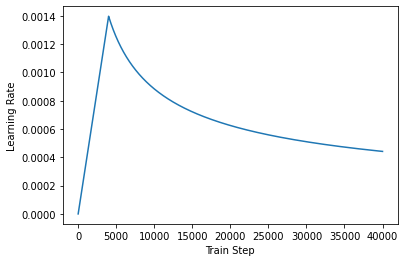

In [13]:
import matplotlib.pyplot as plt

temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

## Build model

In [14]:
_ = mapping_model(x_train)

print(mapping_model.summary())

Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  120448    
_________________________________________________________________
decoder (Decoder)            multiple                  747776    
_________________________________________________________________
dense_52 (Dense)             multiple                  258       
Total params: 868,482
Trainable params: 868,482
Non-trainable params: 0
_________________________________________________________________
None


# Load model checkpoint

In [15]:
checkpoint_file = os.path.join(checkpoint_dir, 'cp.ckpt')

if os.path.isdir(checkpoint_dir) and os.listdir(checkpoint_dir):
    mapping_model.load_weights(checkpoint_file)

## Create training callbacks

In [16]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_file,
    save_weights_only=False,
    verbose=0,
    save_freq='epoch')

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# def scheduler(epoch, lr):
#   if epoch < 10:
#     return lr
#   else:
#     return lr * 0.9

# lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

## Train the model

In [17]:
epochs = 500
steps_per_epoch = 100
validation_steps = 10

mapping_model.fit(train_dataset,
          epochs=epochs,
          steps_per_epoch=steps_per_epoch,
          validation_data=valid_dataset,
          validation_steps=validation_steps,
          callbacks=[checkpoint, early_stop])

Epoch 1/500
100/100 [==============================] - 58s 486ms/step - loss: 0.0119 - mean_squared_error: 0.0012 - val_loss: 0.0078 - val_mean_squared_error: 6.4292e-04
Epoch 2/500
100/100 [==============================] - 46s 456ms/step - loss: 0.0116 - mean_squared_error: 0.0011 - val_loss: 0.0076 - val_mean_squared_error: 6.1937e-04
Epoch 3/500
100/100 [==============================] - 45s 455ms/step - loss: 0.0122 - mean_squared_error: 0.0015 - val_loss: 0.0104 - val_mean_squared_error: 6.4382e-04
Epoch 4/500
100/100 [==============================] - 45s 454ms/step - loss: 0.0118 - mean_squared_error: 0.0011 - val_loss: 0.0095 - val_mean_squared_error: 6.3390e-04
Epoch 5/500
100/100 [==============================] - 45s 454ms/step - loss: 0.0120 - mean_squared_error: 0.0013 - val_loss: 0.0076 - val_mean_squared_error: 6.0856e-04
Epoch 6/500
100/100 [==============================] - 46s 455ms/step - loss: 0.0114 - mean_squared_error: 0.0011 - val_loss: 0.0107 - val_mean_square

## Evaluate model on test dataset

In [18]:
mapping_model.evaluate(test_dataset, steps=500)

500/500 [==============================] - 83s 165ms/step - loss: 0.0114 - mean_squared_error: 8.3053e-04


[0.01143057644367218, 0.0008305320516228676]

### Load Data and Model Checkpoints

In [27]:
import ddsp.training
from ddsp.training.preprocessing import F0LoudnessPreprocessor
import gin
import matplotlib.pyplot as plt
from IPython.display import Audio

sr = 16000

ddsp_dir = os.path.normpath('/content/drive/My Drive/nsynth_guitar/train_30000')

# Parse the gin config.
gin_file = os.path.join(ddsp_dir, 'operative_config-30000.gin')
gin.parse_config_file(gin_file)

# Load model
ddsp_model = ddsp.training.models.Autoencoder()
ddsp_model.restore(ddsp_dir)

def map_func(features):
    inputs, targets = features_map(features)
    return inputs, targets, features

# Create test dataset
data_provider = CompleteTFRecordProvider(
    file_pattern=test_tfrecord_file + '*',
    example_secs=example_secs,
    sample_rate=sample_rate,
    frame_rate=frame_rate,
    map_func=map_func)

dataset = data_provider.get_batch(
    1,
    shuffle=True,
    repeats=-1)

datagen = iter(dataset)

### Get Predictions

In [29]:
def get_preds(inputs, targets, features, num_targets):

  outputs = mapping_model.compute_outputs(inputs, num_targets=num_targets)
  # outputs = mapping_model(inputs)

  f0_variation_pred = outputs[:, :, 0]
  ld_scaled_pred = outputs[:, :, 1]
  # z_pred = outputs[:, :, 2:]

  f0_variation_pred = tf.squeeze(f0_variation_pred)
  ld_scaled_pred = tf.squeeze(ld_scaled_pred)
  # z_pred = tf.squeeze(z_pred)

  f0_scaled = np.squeeze(features['f0_scaled'])
  ld_scaled = np.squeeze(features['ld_scaled'])
  # z = tf.reshape(features['z'], shape=z_pred.shape)

  note_number = features['note_number']
  note_number = tf.squeeze(tf.cast(note_number, dtype=tf.float32))

  f0_variation = f0_scaled * 127.0 - note_number
  f0_variation *= tf.cast(tf.math.less_equal(tf.math.abs(f0_variation), 1.0),
                            dtype=tf.float32)

  plt.figure(figsize=(12, 6))

  plt.subplot(2, 2, 1)
  plt.plot(f0_variation, label='f0_variation')
  plt.plot(f0_variation_pred, label='f0_variation prediction')
  plt.xlabel('time')
  plt.legend()

  plt.subplot(2, 2, 2)
  plt.plot(ld_scaled, label='ld_scaled')
  plt.plot(ld_scaled_pred, label='ld_scaled prediction')
  plt.xlabel('time')
  plt.legend()

  # plt.subplot(2, 2, 3)
  # plt.xlabel('time')
  # plt.ylabel('z')
  # plt.plot(z)
  # plt.ylim([-7., 7.])

  # plt.subplot(2, 2, 4)
  # plt.xlabel('time')
  # plt.ylabel('z prediction')
  # plt.plot(z_pred)
  # plt.ylim([-7., 7.])

  plt.show()

  f0_scaled_pred = (f0_variation_pred + note_number) / 127.0

  f0_scaled_pred = tf.expand_dims(f0_scaled_pred, axis=0)
  ld_scaled_pred = tf.expand_dims(ld_scaled_pred, axis=0)

  # Update the features with predicted f0 and ld
  features['f0_scaled'] = tf.convert_to_tensor(f0_scaled_pred)
  features['ld_scaled'] = tf.convert_to_tensor(ld_scaled_pred)

  f0_hz, loudness_db = F0LoudnessPreprocessor.invert_scaling(
      f0_scaled_pred, ld_scaled_pred)

  features['f0_hz'] = f0_hz
  features['loudness_db'] = loudness_db
  # features['z'] = z_pred

  ddsp_outputs = ddsp_model(features, training=False)
  audio_pred = ddsp_model.get_audio_from_outputs(ddsp_outputs)

  return features['audio'], audio_pred

In [24]:
inputs, targets, features = next(datagen)
print(features['sample_name'])

tf.Tensor([[b'guitar_acoustic_014-070-050']], shape=(1, 1), dtype=string)


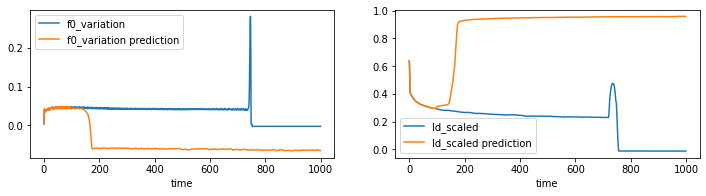

In [33]:
audio, audio_pred = get_preds(inputs, targets, features, num_targets=100)

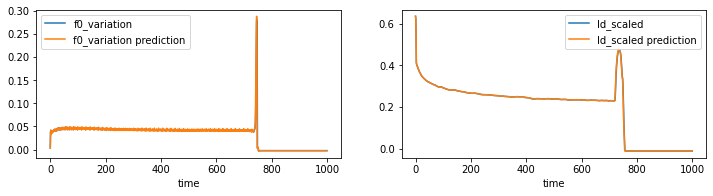

In [30]:
audio, audio_pred = get_preds(inputs, targets, features, num_targets=1000)

In [31]:
print('Original Audio')
Audio(audio, rate=sr)

Original Audio


In [32]:
print('Predicted Audio')
Audio(audio_pred, rate=sr)

Predicted Audio
